# Step 1: Imports

In [1]:
from typing import List, Tuple
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

def load_raw_data(filename: str) -> pd.DataFrame:
    mens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/M{filename}.csv"
    weomens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/W{filename}.csv"
    df_mens = pd.read_csv(mens_filepath)
    df_mens["Gender"] = "M"
    df_weomens = pd.read_csv(weomens_filepath)
    df_weomens["Gender"] = "W"
    return pd.concat([df_mens, df_weomens])

# Step 2: Load the data

In [2]:
RegularSeasonDetailedResults = load_raw_data("RegularSeasonDetailedResults")
RegularSeasonDetailedResults.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000,178155.000000
mean,2014.458292,70.704095,2080.049839,73.996312,2077.204524,61.088142,0.062143,26.078140,56.898414,6.841121,18.533867,14.998911,21.070613,11.271393,26.181050,14.787017,13.719289,7.638781,3.749269,16.501423,21.980281,57.220420,5.672325,19.093284,11.455255,16.901423,11.079436,22.071241,11.221128,15.344060,6.445438,2.852589,18.658702
std,5.503269,35.730148,982.347287,11.382860,985.716118,11.357142,0.288683,4.800847,7.864070,3.146255,6.257064,6.124677,7.998482,4.489884,5.102937,4.508559,4.436739,3.487076,2.436578,4.717189,4.494902,7.806524,2.807640,6.298374,5.243836,7.004884,4.424218,4.716859,3.763142,5.012779,2.987577,2.042899,5.168992
min,2003.000000,0.000000,1101.000000,30.000000,1101.000000,11.000000,0.000000,9.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,40.000000,1258.000000,66.000000,1250.000000,53.000000,0.000000,23.000000,52.000000,5.000000,14.000000,11.000000,15.000000,8.000000,23.000000,12.000000,11.000000,5.000000,2.000000,14.000000,19.000000,52.000000,4.000000,15.000000,8.000000,12.000000,8.000000,19.000000,9.000000,12.000000,4.000000,1.000000,16.000000
50%,2015.000000,74.000000,1407.000000,73.000000,1401.000000,61.000000,0.000000,26.000000,57.000000,7.000000,18.000000,15.000000,21.000000,11.000000,26.000000,14.000000,13.000000,7.000000,3.000000,17.000000,22.000000,57.000000,5.000000,19.000000,11.000000,16.000000,11.000000,22.000000,11.000000,15.000000,6.000000,3.000000,19.000000
75%,2019.000000,101.000000,3239.000000,81.000000,3239.000000,68.000000,0.000000,29.000000,62.000000,9.000000,22.000000,19.000000,26.000000,14.000000,29.000000,18.000000,16.000000,10.000000,5.000000,19.000000,25.000000,62.000000,7.000000,23.000000,15.000000,21.000000,14.000000,25.000000,14.000000,18.000000,8.000000,4.000000,22.000000
max,2023.000000,132.000000,3477.000000,149.000000,3477.000000,144.000000,6.000000,58.000000,113.000000,26.000000,58.000000,50.000000,67.000000,45.000000,58.000000,45.000000,40.000000,36.000000,21.000000,41.000000,53.000000,111.000000,25.000000,80.000000,42.000000,61.000000,38.000000,53.000000,34.000000,49.000000,26.000000,18.000000,47.000000


In [3]:
NCAATourneyDetailedResults = load_raw_data("NCAATourneyDetailedResults")
NCAATourneyDetailedResults.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,2013.528386,139.710159,2045.650398,75.634462,2046.729582,62.015936,0.059761,26.939243,57.287351,6.655876,17.590637,15.100100,20.656873,11.247510,26.676793,14.885458,12.140936,6.912849,4.184263,15.668327,22.575199,58.981574,5.938247,20.037849,10.927291,15.542829,11.229582,21.421813,11.409363,13.059761,6.047809,2.977092,18.377490
std,5.278322,4.228837,969.483204,11.172242,970.123243,10.992444,0.268629,5.006453,7.628951,3.101281,6.027652,5.948663,7.566697,4.361469,5.312048,4.691566,4.148412,3.284223,2.649216,4.042198,4.386454,7.673206,2.828457,6.357993,5.144033,6.700226,4.469526,4.563548,3.690809,4.417929,2.866869,2.064595,4.235698
min,2003.000000,134.000000,1101.000000,47.000000,1101.000000,21.000000,0.000000,13.000000,34.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,0.000000,0.000000,3.000000,8.000000,37.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2.000000,2.000000,0.000000,0.000000,3.000000
25%,2010.000000,137.000000,1257.000000,68.000000,1266.000000,55.000000,0.000000,24.000000,52.000000,4.000000,13.000000,11.000000,15.000000,8.000000,23.000000,12.000000,9.000000,5.000000,2.000000,13.000000,20.000000,54.000000,4.000000,16.000000,7.000000,11.000000,8.000000,18.000000,9.000000,10.000000,4.000000,1.000000,15.000000
50%,2014.000000,138.000000,1403.000000,75.000000,1410.000000,62.000000,0.000000,27.000000,57.000000,6.000000,17.000000,15.000000,20.000000,11.000000,26.000000,15.000000,12.000000,6.000000,4.000000,15.000000,22.000000,59.000000,6.000000,20.000000,10.000000,15.000000,11.000000,21.000000,11.000000,13.000000,6.000000,3.000000,18.000000
75%,2018.000000,141.000000,3235.000000,83.000000,3234.250000,69.000000,0.000000,30.000000,62.000000,9.000000,21.000000,19.000000,25.000000,14.000000,30.000000,18.000000,15.000000,9.000000,6.000000,18.000000,26.000000,64.000000,8.000000,24.000000,14.000000,20.000000,14.000000,24.000000,14.000000,16.000000,8.000000,4.000000,21.000000
max,2022.000000,155.000000,3462.000000,140.000000,3462.000000,105.000000,2.000000,59.000000,91.000000,18.000000,41.000000,38.000000,48.000000,27.000000,54.000000,38.000000,34.000000,24.000000,16.000000,31.000000,38.000000,85.000000,18.000000,57.000000,31.000000,39.000000,29.000000,42.000000,29.000000,32.000000,22.000000,13.000000,33.000000


In [4]:
NCAATourneySeeds = load_raw_data("NCAATourneySeeds")
NCAATourneySeeds.describe()

,Season,TeamID
count,3962.000000,3962.000000
mean,2005.756436,2066.867239
std,10.015312,977.947592
min,1985.000000,1101.000000
25%,1999.000000,1264.250000
50%,2006.000000,1406.500000
75%,2014.000000,3242.000000
max,2022.000000,3464.000000


# Step 3: Prepare the data



In [5]:
def process_detailed_results(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df = clean_detailed_results(df)
    df = aggregate_detailed_results(df)
    df = compute_percentages(df)
    return df

def clean_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(["WLoc", "DayNum"], axis=1)

def reshape_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    winner_columns, looser_columns = split_winner_and_looser_columns(df)
    df_winner = df.copy()
    df_winner = df_winner[winner_columns]
    df_winner.columns = clean_column_names(df_winner)
    df_winner["Win"] = 1
    df_looser = df.copy()
    df_looser = df_looser[looser_columns]
    df_looser.columns = clean_column_names(df_looser)
    df_looser["Win"] = 0
    return pd.concat([df_winner, df_looser], ignore_index=True)

def aggregate_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    df = reshape_detailed_results(df)
    df_agg = df.groupby(["Season", "TeamID"]).agg("median")
    return df_agg.reset_index()

def compute_percentages(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df["FGP"] =  df["FGM"] / df["FGA"]
    df["FGP3"] =  df["FGM3"] / df["FGA3"]
    df["FTP"] =  df["FTM"] / df["FTA"]
    return df

def split_winner_and_looser_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    winner_columns = [name for name in df.columns if not name.startswith("L")]
    looser_columns = [name for name in df.columns if not name.startswith("W")]
    return winner_columns, looser_columns

def clean_column_names(df: pd.DataFrame) -> List[str]:
    column_names = [
        name[1:] if 
        name.startswith("L") or name.startswith("W")
        else name 
        for name in df.columns
    ]
    return column_names

# Test data
test_df = pd.DataFrame([
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 1, "Wstat2": 2, "Lstat2": 3 },
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 4, "Wstat2": 5, "Lstat2": 6 },
])
expected_column_names = [
    "Season", "TeamID", "TeamID", "stat1", "stat2", "stat2"
]
expected_column_split = (
    ["Season", "WTeamID", "stat1", "Wstat2"], 
    ["Season", "LTeamID", "stat1", "Lstat2"]
)
expected_reshaped_df = pd.DataFrame([
    { "Season": 1, "TeamID": "A", "stat1": 1, "stat2": 2, "Win": 1 },
    { "Season": 1, "TeamID": "A", "stat1": 4, "stat2": 5, "Win": 1 },
    { "Season": 1, "TeamID": "B", "stat1": 1, "stat2": 3, "Win": 0 },
    { "Season": 1, "TeamID": "B", "stat1": 4, "stat2": 6, "Win": 0 },
    
])
expected_aggregated_df = pd.DataFrame([
    {"Season": 1, "TeamID": "A", "stat1": 2.5, "stat2": 3.5, "Win": 1.0 },
    {"Season": 1, "TeamID": "B","stat1": 2.5, "stat2": 4.5, "Win": 0.0 },
])
test_df_copy = test_df.copy()

# Tests
assert clean_column_names(test_df) == expected_column_names, "Function clean_column_names failed."
assert split_winner_and_looser_columns(test_df) == expected_column_split, "Function split_winner_and_looser_columns failed."
assert expected_reshaped_df.equals(reshape_detailed_results(test_df)), "Function reshape_detailed_results failed."
assert expected_aggregated_df.equals(aggregate_detailed_results(test_df)), "Function aggregate_detailed_results failed."

In [6]:
ProcessedRegularSeasonDetailedResults = process_detailed_results(
    RegularSeasonDetailedResults
)
ProcessedRegularSeasonDetailedResults.describe()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Win,FGP,FGP3,FTP
count,12135.000000,12135.000000,12135.000000,12135.0,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.00000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000
mean,2014.517017,2089.380058,67.144293,0.0,23.831932,56.798764,6.058385,18.552452,12.713391,18.401360,10.858962,23.909271,12.741904,14.32843,6.827235,3.033869,17.205933,0.489493,0.419918,0.324541,0.692124
std,5.575842,986.374172,7.010613,0.0,2.529356,4.000150,1.645062,3.998587,2.422019,3.298866,2.359089,2.302109,2.099513,2.51699,1.659208,1.141526,3.614567,0.492268,0.037190,0.044573,0.060804
min,2003.000000,1101.000000,38.500000,0.0,13.000000,39.000000,0.000000,3.000000,4.500000,6.500000,3.000000,15.000000,5.000000,7.00000,3.000000,0.000000,0.000000,0.000000,0.275862,0.000000,0.457143
25%,2011.000000,1255.000000,62.500000,0.0,22.000000,54.000000,5.000000,16.000000,11.000000,16.000000,9.000000,22.000000,11.000000,12.50000,6.000000,2.000000,16.000000,0.000000,0.396226,0.294118,0.650000
50%,2015.000000,1406.000000,67.000000,0.0,24.000000,57.000000,6.000000,18.000000,13.000000,18.000000,11.000000,24.000000,13.000000,14.00000,7.000000,3.000000,18.000000,0.500000,0.421053,0.326923,0.690476
75%,2019.000000,3242.000000,72.000000,0.0,25.500000,59.000000,7.000000,21.000000,14.000000,20.500000,12.000000,25.000000,14.000000,16.00000,8.000000,4.000000,19.000000,1.000000,0.446429,0.352941,0.733333
max,2023.000000,3477.000000,99.000000,0.0,36.000000,81.000000,13.500000,41.500000,22.000000,31.000000,22.000000,34.000000,23.500000,28.00000,16.000000,9.000000,28.000000,1.000000,0.562500,0.500000,1.000000


In [7]:
ProcessedNCAATourneyDetailedResults = process_detailed_results(
    NCAATourneyDetailedResults
)
ProcessedNCAATourneyDetailedResults["Season"] += 1
ProcessedNCAATourneyDetailedResults.describe()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Win,FGP,FGP3,FTP
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2034.000000
mean,2014.527710,2046.475233,65.795733,0.044385,23.690289,58.164787,6.191761,19.493624,12.066699,16.991663,11.010790,23.017656,12.389897,12.862678,6.255272,3.210888,17.558117,0.377146,0.409195,0.317894,0.707800
std,5.278327,970.130845,10.973542,0.210999,4.269685,6.814759,2.519504,5.868360,4.810207,6.198700,3.882806,4.467820,3.571197,3.860042,2.650049,1.989462,3.780883,0.411128,0.068118,0.093978,0.119369
min,2004.000000,1101.000000,29.000000,0.000000,8.000000,37.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2.000000,2.000000,0.000000,0.000000,7.000000,0.000000,0.137931,0.000000,0.000000
25%,2011.000000,1265.000000,59.000000,0.000000,21.000000,54.000000,4.000000,15.500000,9.000000,13.000000,8.000000,20.000000,10.000000,10.000000,4.500000,2.000000,15.000000,0.000000,0.365301,0.257143,0.642857
50%,2015.000000,1409.000000,66.500000,0.000000,24.000000,58.000000,6.000000,19.000000,12.000000,17.000000,11.000000,23.000000,12.000000,12.500000,6.000000,3.000000,17.000000,0.500000,0.413223,0.318182,0.714286
75%,2019.000000,3234.000000,73.000000,0.000000,26.500000,62.500000,8.000000,23.000000,15.000000,21.000000,13.500000,26.000000,15.000000,15.000000,8.000000,4.000000,20.000000,0.500000,0.457627,0.380952,0.785714
max,2023.000000,3462.000000,100.000000,2.000000,37.000000,85.000000,16.000000,57.000000,31.000000,42.000000,29.000000,42.000000,29.000000,32.000000,22.000000,13.000000,33.000000,1.000000,0.621359,0.666667,1.000000


In [8]:
def process_seeds(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    mask = df["Season"] > 2002
    df = df[mask]
    df["Seed"] = df["Seed"].str.replace(r"\D+","", regex=True)
    df["Seed"] = df["Seed"].astype(int)
    return df

In [9]:
ProcessedNCAATourneySeeds = process_seeds(NCAATourneySeeds)
ProcessedNCAATourneySeeds.describe()

,Season,Seed,TeamID
count,2488.000000,2488.000000,2488.000000
mean,2012.175241,8.624196,2270.131833
std,5.652573,4.644742,1000.849079
min,2003.000000,1.000000,1101.000000
25%,2007.000000,5.000000,1290.000000
50%,2012.000000,9.000000,1459.000000
75%,2017.000000,13.000000,3278.000000
max,2022.000000,16.000000,3462.000000


## Merge features

In [10]:
features = pd.merge(
    ProcessedRegularSeasonDetailedResults,
    ProcessedNCAATourneyDetailedResults,
    how="inner",
    on=["Season", "TeamID"],
    suffixes=("Reg", "Tou")
)

features = features.merge(
    ProcessedNCAATourneySeeds,
    how="inner",
    on=["Season", "TeamID"]
)

features.describe()

,Season,TeamID,ScoreReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,WinReg,FGPReg,FGP3Reg,FTPReg,ScoreTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,WinTou,FGPTou,FGP3Tou,FTPTou,Seed
count,982.000000,982.000000,982.000000,982.0,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,980.000000,982.000000
mean,2013.409369,2090.717923,73.341650,0.0,26.121690,58.155295,6.412424,18.496436,13.865071,19.603360,11.926171,25.317210,14.739308,13.104379,7.276986,3.753055,16.704175,0.995927,0.449493,0.345591,0.708459,67.698065,0.047862,24.419552,58.283096,6.101833,18.845214,12.531059,17.491853,11.488798,23.624236,12.971996,12.806008,6.408859,3.442974,17.548371,0.491853,0.420656,0.324199,0.713357,6.759674
std,4.693613,977.228119,6.013968,0.0,2.470872,4.123670,1.691698,4.191241,2.412880,3.256337,2.242418,2.338448,2.178400,2.072231,1.809241,1.259972,2.051655,0.059592,0.032383,0.042370,0.056332,10.590478,0.220625,4.106463,6.475808,2.445495,5.684849,4.701357,5.989154,3.747765,4.346879,3.512317,3.628702,2.646732,1.980230,3.677556,0.424690,0.064524,0.093167,0.116004,4.312380
min,2004.000000,1104.000000,56.000000,0.0,20.000000,46.500000,2.000000,6.000000,6.000000,10.500000,5.000000,18.000000,8.000000,7.000000,3.000000,1.000000,9.000000,0.000000,0.347107,0.200000,0.522727,30.000000,0.000000,12.000000,37.000000,0.000000,5.000000,0.000000,0.000000,1.000000,9.000000,2.000000,4.000000,1.000000,0.000000,9.000000,0.000000,0.162162,0.000000,0.000000,1.000000
25%,2011.000000,1272.000000,69.000000,0.0,24.000000,55.000000,5.000000,16.000000,12.000000,17.125000,10.000000,24.000000,13.000000,12.000000,6.000000,3.000000,15.000000,1.000000,0.428571,0.315789,0.666667,61.000000,0.000000,21.500000,54.000000,4.000000,15.000000,9.000000,13.500000,9.000000,21.000000,11.000000,10.000000,4.500000,2.000000,15.000000,0.000000,0.379810,0.263158,0.651921,3.000000
50%,2014.000000,1425.000000,73.000000,0.0,26.000000,58.000000,6.000000,18.000000,14.000000,20.000000,12.000000,25.000000,15.000000,13.000000,7.000000,4.000000,17.000000,1.000000,0.449771,0.347826,0.707317,69.000000,0.000000,24.500000,58.000000,6.000000,18.500000,12.500000,17.500000,11.000000,23.500000,13.000000,12.250000,6.000000,3.000000,17.000000,0.500000,0.422921,0.322581,0.723180,6.000000
75%,2017.000000,3242.750000,77.500000,0.0,28.000000,61.000000,7.500000,21.000000,15.500000,22.000000,13.000000,27.000000,16.000000,14.000000,8.000000,4.500000,18.000000,1.000000,0.471698,0.375000,0.750000,75.000000,0.000000,27.000000,62.500000,7.500000,22.000000,15.500000,21.500000,14.000000,27.000000,15.000000,15.000000,8.000000,5.000000,20.000000,1.000000,0.464286,0.384615,0.786094,10.000000
max,2022.000000,3462.000000,91.000000,0.0,36.000000,76.000000,12.000000,35.000000,21.000000,30.000000,19.000000,34.000000,23.500000,20.000000,13.000000,9.000000,24.000000,1.000000,0.562500,0.473684,0.888889,100.000000,2.000000,37.000000,85.000000,15.000000,50.000000,27.500000,42.000000,29.000000,42.000000,29.000000,32.000000,20.500000,13.000000,33.000000,1.000000,0.621359,0.666667,1.000000,16.000000


## Build Dataset

In [11]:
def get_outcomes(df):
    input_rows = df.to_records()
    output_rows = [parse_row(input_row) for input_row in input_rows]
    out_df = pd.DataFrame(output_rows)
    out_df = out_df[out_df["Season"] < 2017]
    return out_df

def parse_row(row):
    season = row['Season']
    winning_team_id = row['WTeamID']
    losing_team_id = row['LTeamID']
    if winning_team_id < losing_team_id:
        small_id = winning_team_id
        big_id = losing_team_id
        outcome = 1
    elif losing_team_id < winning_team_id:
        small_id = losing_team_id
        big_id = winning_team_id
        outcome = 0
    record = {
        "ID": f"{season}_{small_id}_{big_id}",
        'Season': season,
        'LowID': small_id,
        'HighID': big_id,
        'Win': outcome
    }
    return record

In [12]:
outcomes = get_outcomes(NCAATourneyDetailedResults)
print(outcomes.shape)
outcomes.describe()

(1355, 5)


,Season,LowID,HighID,Win
count,1355.000000,1355.000000,1355.000000,1355.000000
mean,2010.692251,1881.616974,2001.932103,0.502583
std,3.856804,938.038044,933.571896,0.500178
min,2003.000000,1102.000000,1125.000000,0.000000
25%,2008.000000,1196.000000,1326.000000,0.000000
50%,2011.000000,1278.000000,1433.000000,1.000000
75%,2014.000000,3163.000000,3274.000000,1.000000
max,2016.000000,3438.000000,3462.000000,1.000000


In [13]:
def merge_outcomes_with_features(outcomes: pd.DataFrame, features: pd.DataFrame) -> pd.DataFrame:
    data = pd.merge(
        outcomes, 
        features, 
        how="left", 
        left_on=["Season", "HighID"], 
        right_on=["Season", "TeamID"]
    )
    data = pd.merge(
        data, 
        features, 
        how="left", 
        left_on=["Season", "LowID"], 
        right_on=["Season", "TeamID"],
        suffixes=("High", "Low")
    )
    data.drop(
        ["Season", "HighID", "LowID","TeamIDHigh","TeamIDLow"], 
        axis=1, 
        inplace=True
    )
    data.set_index("ID", inplace=True)
    return data

In [14]:
data = merge_outcomes_with_features(outcomes, features)
print(data.shape)
data.describe()

(1355, 81)


,Win,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,WinRegHigh,FGPRegHigh,FGP3RegHigh,FTPRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,WinTouHigh,FGPTouHigh,FGP3TouHigh,FTPTouHigh,SeedHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,WinRegLow,FGPRegLow,FGP3RegLow,FTPRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,WinTouLow,FGPTouLow,FGP3TouLow,FTPTouLow,SeedLow
count,1355.000000,814.000000,814.0,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.00000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,813.000000,814.000000,815.000000,815.0,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.0,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,814.000000,815.000000
mean,0.502583,73.157862,0.0,25.965602,57.716830,6.085381,17.535627,14.382064,20.308354,12.342752,25.098894,14.626536,13.041155,7.388206,3.795455,16.74570,0.997543,0.450361,0.346025,0.709118,68.360565,0.041155,24.479730,57.799754,5.990172,18.453931,13.205160,18.355651,11.856265,23.866093,13.120393,12.658477,6.527641,3.486486,17.278870,0.565111,0.424874,0.325366,0.717358,5.084767,74.451534,0.0,26.631902,58.111043,6.251534,17.576074,14.389571,20.396933,12.433742,25.512883,15.231288,13.306748,7.625767,4.095706,16.584049,1.0,0.458619,0.354273,0.706864,69.466871,0.056442,24.916564,57.977301,5.984049,17.909202,13.180982,18.355828,11.938650,24.143558,13.557055,13.146626,6.777914,3.691411,17.463190,0.571166,0.431598,0.336648,0.719196,5.206135
std,0.500178,5.636647,0.0,2.286394,3.984978,1.511667,3.730128,2.255696,2.949577,2.207522,2.232845,2.128402,2.216002,1.890068,1.211717,2.00962,0.049538,0.031822,0.042608,0.055176,9.738173,0.204113,3.823668,6.322353,2.336912,5.303811,4.633059,6.028559,3.499725,3.977010,3.361877,3.395163,2.680536,1.918657,3.566741,0.415045,0.057969,0.089677,0.104975,3.814446,5.873025,0.0,2.588025,4.234264,1.668812,3.901629,2.385604,3.202107,2.103852,2.411993,2.457414,2.068190,1.875210,1.529816,2.145503,0.0,0.033485,0.043820,0.056956,9.377760,0.250070,3.743352,6.409340,2.345023,5.781524,4.259915,5.602168,3.558727,4.012144,3.497032,3.400883,2.743275,2.116868,3.782946,0.424050,0.059205,0.092191,0.106215,4.021650
min,0.000000,57.000000,0.0,20.000000,46.500000,2.000000,6.500000,6.000000,10.500000,6.000000,19.000000,8.000000,7.000000,3.000000,1.000000,12.00000,0.000000,0.347107,0.200000,0.522727,30.000000,0.000000,12.000000,37.000000,1.000000,5.000000,0.000000,0.000000,1.000000,9.000000,2.000000,5.000000,1.000000,0.000000,10.000000,0.000000,0.200000,0.052632,0.000000,1.000000,56.000000,0.0,20.500000,46.500000,2.000000,6.000000,8.000000,11.000000,5.000000,19.000000,9.500000,9.000000,3.000000,1.000000,10.000000,1.0,0.347107,0.200000,0.545455,37.000000,0.000000,13.000000,42.000000,0.500000,6.000000,0.000000,0.000000,3.000000,10.000000,2.000000,5.000000,1.000000,0.000000,9.000000,0.000000,0.250000,0.052632,0.250000,1.000000
25%,0.000000,69.000000,0.0,24.000000,55.000000,5.000000,15.000000,13.000000,18.000000,11.000000,23.500000,13.000000,11.500000,6.000000,3.000000,15

## Train Test Split 

In [15]:
# For splitting data
from sklearn.model_selection import train_test_split

# Create train, validate, and test sets.
X = data.copy().drop("Win", axis=1)
y = data["Win"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

X_train.shape

(1016, 80)

In [16]:
def partition_features(df: pd.DataFrame, cardnality_threshold: int) -> Tuple[pd.DataFrame]:
    cat_cols = [name for name, data_type in df.dtypes.items() if data_type == object]
    num_cols = list(set(df.columns) - set(cat_cols))
    col_cardnality = {col_name: X_train[col_name].nunique() for col_name in cat_cols}
    cat_cols_high = []
    cat_cols_low = []
    for name, cardnality in col_cardnality.items():
        if cardnality > cardnality_threshold:
            cat_cols_high.append(name)
        else:
            cat_cols_low.append(name)
    return num_cols, cat_cols_high, cat_cols_low

In [17]:
num_cols, cat_cols_high, cat_cols_low = partition_features(X_train, 10)
print(num_cols)
print(cat_cols_high)
print(cat_cols_low)

['SeedLow', 'FGP3TouHigh', 'PFTouHigh', 'TORegHigh', 'FGPTouLow', 'FGM3TouHigh', 'SeedHigh', 'FGMTouLow', 'FGM3TouLow', 'FGARegHigh', 'FTATouLow', 'FTARegLow', 'ScoreRegHigh', 'NumOTRegLow', 'BlkTouHigh', 'StlTouHigh', 'FGPTouHigh', 'FGMRegHigh', 'FTMRegHigh', 'WinRegHigh', 'FGMRegLow', 'FGATouLow', 'AstTouLow', 'FTPRegLow', 'FGA3TouLow', 'ScoreTouLow', 'ScoreRegLow', 'ORRegLow', 'PFRegLow', 'FTARegHigh', 'DRTouHigh', 'ORTouLow', 'FGA3RegLow', 'FGP3RegHigh', 'FTMTouHigh', 'BlkTouLow', 'DRRegLow', 'DRTouLow', 'WinRegLow', 'FTPRegHigh', 'StlTouLow', 'FGARegLow', 'FGPRegHigh', 'AstRegLow', 'TOTouLow', 'StlRegLow', 'ORRegHigh', 'FGA3TouHigh', 'TORegLow', 'WinTouLow', 'StlRegHigh', 'AstTouHigh', 'FGATouHigh', 'FGP3TouLow', 'ORTouHigh', 'FTPTouLow', 'FTMTouLow', 'FGMTouHigh', 'FGM3RegHigh', 'FGPRegLow', 'NumOTRegHigh', 'TOTouHigh', 'FTATouHigh', 'FGA3RegHigh', 'BlkRegHigh', 'BlkRegLow', 'DRRegHigh', 'FTPTouHigh', 'WinTouHigh', 'FTMRegLow', 'AstRegHigh', 'FGM3RegLow', 'PFRegHigh', 'NumOTTouHi

### Data preperation pipelines

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy="median")

# Preprocessing for high cardnality categorical data
cat_high_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OrdinalEncoder(handle_unknown="ignore"))
])

# Preprocessing for low cardnality categorical data
cat_low_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_cols),
        ("cat_high", cat_high_transformer, cat_cols_high),
        ("cat_low", cat_low_transformer, cat_cols_low)
    ])

### Preprocess Data

In [19]:
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Step 4: Train a model


### Setup Hyperparameter Tuning
See https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, log_loss, brier_score_loss
from xgboost import XGBClassifier
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=Warning)

In [21]:
space={
    "n_estimators": hp.quniform("n_estimators", 250, 3000, 250),
    "learning_rate": hp.uniform("learning_rate", 0.1, 0.3),
    "max_depth": hp.quniform("max_depth", 2, 12, 1),
    "reg_lambda": hp.uniform("reg_lambda", 50, 250),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.05, 1),
    "tree_method": "gpu_hist",
    "random_state": 42
}

def objective(space):
    regressor=XGBClassifier(
        n_estimators = int(space["n_estimators"]),
        learning_rate = space["learning_rate"],
        max_depth = int(space["max_depth"]),
        reg_lambda = space["reg_lambda"],
        colsample_bytree = space["colsample_bytree"],
        tree_method = space["tree_method"],
        random_state = space["random_state"],
    )
    evaluation = [(X_train_processed, y_train), (X_valid_processed, y_valid)]
    regressor.fit(
        X_train_processed, y_train,
        eval_set=evaluation,
        eval_metric="auc",
        early_stopping_rounds=20,
        verbose=False
    )
    preds = regressor.predict(X_valid_processed)
    score = brier_score_loss(y_valid, preds)
    return {"loss": score, "status": STATUS_OK }

In [22]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)
print(best_hyperparams)

100%|██████████| 200/200 [00:38<00:00,  5.22trial/s, best loss: 0.27728613569321536]
{'colsample_bytree': 0.294778421726842, 'learning_rate': 0.29848135617039795, 'max_depth': 2.0, 'n_estimators': 250.0, 'reg_lambda': 125.49802164454087}


Brier Score: 0.3215339233038348


<AxesSubplot:>

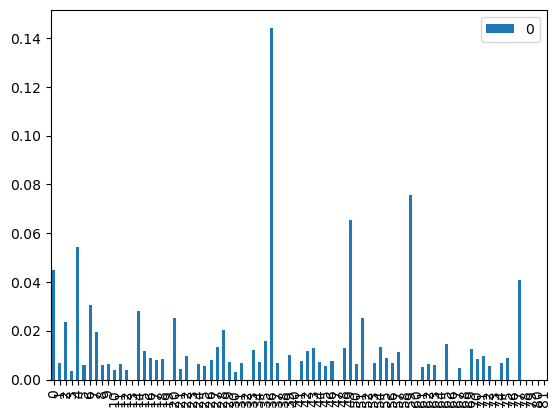

In [23]:
# Define model
model = XGBClassifier(
    n_estimators = int(best_hyperparams["n_estimators"]),
    max_depth = int(best_hyperparams["max_depth"]),
    learning_rate = best_hyperparams["learning_rate"],
    colsample_bytree = best_hyperparams["colsample_bytree"],
    reg_lambda = best_hyperparams["reg_lambda"], 
    tree_method = "gpu_hist",
    random_state = 42
)
model.fit(X_train_processed, y_train,
          early_stopping_rounds=20, 
          eval_set=[(X_valid_processed, y_valid)],
          verbose=False)
preds = model.predict(X_valid_processed)
print("Brier Score:", brier_score_loss(y_valid, preds))
pd.DataFrame(model.feature_importances_).plot.bar()

# Step 5: Submit to the competition

We"ll begin by using the trained model to generate predictions, which we"ll save to a CSV file.

In [24]:
SampleSubmissionWarmup = pd.read_csv("/kaggle/input/warmup-round-march-machine-learning-mania-2023/SampleSubmissionWarmup.csv")

print(SampleSubmissionWarmup.shape)
SampleSubmissionWarmup.tail()

(614319, 2)


,ID,Pred
614314,2022_3469_3471,0.5
614315,2022_3469_3472,0.5
614316,2022_3470_3471,0.5
614317,2022_3470_3472,0.5
614318,2022_3471_3472,0.5


In [25]:
def get_submission_outcomes(sample_submission: pd.DataFrame) -> pd.DataFrame:
    df = sample_submission.copy()
    df.drop("Pred", axis=1, inplace=True)
    df[["Season", "LowID", "HighID"]] = df["ID"].str.split("_", expand=True).astype(int)
    return df

In [26]:
submission_outcomes = get_submission_outcomes(SampleSubmissionWarmup)
print(submission_outcomes.shape)
submission_outcomes.describe()

(614319, 4)


,Season,LowID,HighID
count,614319.000000,614319.000000,614319.000000
mean,2019.412763,2219.367511,2340.658625
std,1.860927,1003.692477,1003.499013
min,2017.000000,1101.000000,1102.000000
25%,2018.000000,1210.000000,1361.000000
50%,2019.000000,1439.000000,1470.000000
75%,2021.000000,3210.000000,3360.000000
max,2022.000000,3471.000000,3472.000000


In [27]:
X_submission = merge_outcomes_with_features(submission_outcomes, features)
print(X_submission.shape)
X_submission.describe()

(614319, 80)


,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,WinRegHigh,FGPRegHigh,FGP3RegHigh,FTPRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,WinTouHigh,FGPTouHigh,FGP3TouHigh,FTPTouHigh,SeedHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,WinRegLow,FGPRegLow,FGP3RegLow,FTPRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,WinTouLow,FGPTouLow,FGP3TouLow,FTPTouLow,SeedLow
count,49144.000000,49144.0,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49499.000000,49499.0,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.00000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000
mean,74.566336,0.0,26.820497,59.765180,6.940288,20.198559,12.922442,18.051563,11.231890,25.843440,14.775568,12.571433,6.906825,3.726315,16.321341,0.989470,0.449025,0.342150,0.716187,68.773340,0.047768,25.129466,59.582197,6.422117,19.775547,11.912431,16.661953,10.963210,24.090479,12.940359,12.229865,5.977566,3.719671,17.222316,0.533473,0.424044,0.326088,0.712022,6.509849,75.046708,0.0,27.217287,59.972828,6.992687,20.388119,12.776723,17.892220,11.197004,25.906069,15.320501,12.743106,7.000717,3.762207,16.218156,0.996293,0.453818,0.341709,0.715200,69.530162,0.024112,25.470959,59.627447,6.447858,19.731671,11.986343,16.758712,10.834795,23.774793,13.383119,12.44410,6.237783,3.537587,17.254217,0.519899,0.428410,0.326494,0.713708,6.861351
std,6.192280,0.0,2.447293,3.844439,1.783260,4.343014,2.220221,2.857248,2.401486,2.375018,2.071337,2.001004,1.666071,1.115731,1.913355,0.090591,0.032639,0.040398,0.055045,11.306789,0.229821,4.364509,5.889314,2.522260,5.804685,4.299554,5.356204,3.696972,4.918266,3.683506,3.615624,2.377517,1.975872,3.650031,0.427875,0.073481,0.097938,0.114460,4.283826,6.376330,0.0,2.602603,3.660747,1.904201,4.811555,2.207888,2.953934,2.195366,2.615746,2.377765,1.861887,1.697928,1.212708,1.956835,0.048425,0.032901,0.042358,0.055797,10.961831,0.163703,4.318365,5.879381,2.510879,5.747769,4.430901,5.502889,3.745145,4.496815,3.931441,3.55931,2.531988,1.923293,3.508644,0.420335,0.066775,0.091520,0.117443,4.446288
min,61.000000,0.0,21.000000,50.000000,2.500000,8.500000,7.000000,11.000000,6.000000,18.000000,10.000000,8.000000,3.000000,1.000000,9.000000,0.000000,0.351562,0.227273,0.562500,31.000000,0.000000,12.000000,40.000000,0.000000,7.000000,2.000000,3.000000,3.000000,9.000000,3.000000,4.000000,1.000000,0.000000,9.000000,0.000000,0.162162,0.000000,0.300000,1.000000,61.000000,0.0,21.000000,50.000000,2.500000,8.500000,7.000000,11.000000,6.000000,18.000000,10.000000,8.000000,3.000000,1.000000,9.000000,0.000000,0.351562,0.227273,0.562500,31.000000,0.000000,12.000000,40.000000,0.000000,7.000000,2.000000,3.000000,3.000000,9.000000,3.000000,4.00000,1.000000,0.000000,9.000000,0.000000,0.162162,0.000000,0.300000,1.000000
25%,71.000000

In [28]:
X_submission_processed = preprocessor.transform(X_submission)

In [29]:
# Use the model to generate predictions

X_processed  = preprocessor.transform(X)
model.fit(X_processed, y)

predictions = model.predict(X_submission_processed)

# Save the predictions to a CSV file
output = pd.DataFrame({"ID": X_submission.index,
                       "Pred": predictions})
output.to_csv("submission.csv", index=False)
print(output.shape)

(614319, 2)
